In [1]:
using Gadfly

## Parámetros del sistema

In [2]:
#Aquí se pueden hacer cambios para realizar varios muestreos
side = 50
size = side*side
#ntrials = convert(Int64, trunc(side^3.5)) # Es buena idea que vaya como side^3 pero tal vez requiera más
ntrials = side^4
nsamples = size # Periodo en el cual se realizan medidas
j_ising = -1.0
#t_env = 2.0
temp_range = linspace(0.1, 4, 40)
directory = pwd()*"/resultados_canonico/"

"/home/rafael/Documentos/Tesis/Programas/Servicio social/resultados_canonico/"

## Funciones 

In [3]:
function change_spin()
    return rand(Int32[-1, 1])
end

change_spin (generic function with 1 method)

In [4]:
function initialize(side::Int, t_env)
    # A bajas temperaturas inicia como un estado base a T = 0 sugerido en el Newman
    # A altas temperaturas inicia como en T = ∞, aleatorio
    if t_env <= 2.1
        if rand() < 0.5
            spins = ones(Int32, side*side)
        else
            spins = -ones(Int32, side*side)
        end
    else
        spins = rand(Int32[-1, 1], side*side)
    end
    neighbors = Vector{Vector{Int64}}(side*side)
    # Para hacerlo en más dimensiones seguro se puede recurrir a la recursión
    for jj in 0:(side-1)
        for ii in 0:(side-1)
            index = jj*side + ii + 1
            #pos[index] = index
            #neighbors[index] = [mod(jj + col, side)*side + mod(ii + row, side) + 1 
            #    for col in -1:1 for row in -1:1]
            #Todos los vecinos laterales y diagonales
            all_nbs = Set([mod(jj + col, side)*side + mod(ii + row, side) + 1 
                for col in -1:1 for row in -1:1])
            # Vecinos diagonales
            diag_nbs = Set([mod(jj + col, side)*side + mod(ii + row, side) + 1 
                for col in [-1,1] for row in [-1,1]])
            #Diferencia simétrica (también se quita el espín central)
            neighbors[index] = collect(symdiff(all_nbs, diag_nbs, index))
        end
    end
    #pos = reshape(pos, side, side)
    #return pos, spin, neighbors
    return spins, neighbors
end
                                        

initialize (generic function with 1 method)

In [5]:
# Solo está el detalle de si dividir la energía solamente entre 2
function montecarlo_cycle(size, spins, neighbors, trials::Int, nsamples, j_ising, t_env)
    #new_system = deepcopy(system)
    nerrors = 0
    energies = Float64[]
    magnets = Float64[]
    e1 = 0.0
    for jj in 1:size
        neighbors_spins = spins[neighbors[jj]] #Lista de los espines vecinos
        e1 = e1 + potential_energy(spins[jj], neighbors_spins, j_ising) 
    end
    e1 = e1/2.0
    push!(energies, e1/size)
    push!(magnets, magnetization(spins)/size)
    for ii in 1:trials
        #try
         #   new_system = montecarlo(size, spins, j_ising, t_env)
        #catch err
        #    nerrors += 1
        #    continue
        #end
        #spins, energy_diff = montecarlo(size, spins, neighbors, j_ising, t_env) 
        energy_change = montecarlo!(size, spins, neighbors, j_ising, t_env) 
        e1 = e1 + energy_change
        #sample(new_system)
    
        if ii%nsamples == 0
            #e1 = 0.0
            #for jj in 1:size
            #    neighbors_spins = spins[neighbors[jj]]
                #e1 += potential_energy(spins[jj], neighbors_spins, j_ising)/2.0
            #end
            push!(energies, e1/size)
            push!(magnets, magnetization(spins)/size)
        end
    end
    return energies, magnets, nerrors
end

montecarlo_cycle (generic function with 1 method)

In [6]:
#function montecarlo(system, delta)
function montecarlo!(size, spins, neighbors, j_ising, t_env)    
    ii = rand(1:size)
    neighbors_spins = spins[neighbors[ii]] #Lista de los espines vecinos
    
    old_energy = potential_energy(spins[ii], neighbors_spins, j_ising)
    
    #En la simulación en el canónico, como solo se voltea el espín central,
    #resulta que trial_energy = -old_energy, así que no es necesario calcularla
    trial_spin = -spins[ii]
    #trial_energy = potential_energy(trial_spin, neighbors_spins, j_ising)

    energy_diff = -2.0*old_energy
    energy_change = 0.0
    # Y hay maneras de optimizar más guardando listas de todas las posibles energías
    # Pero lo dejaré así
    if metropolis_step(energy_diff/t_env)
        spins[ii] = trial_spin
        energy_change = energy_diff
    end
    #return spins, energy_change
    return energy_change
end

montecarlo! (generic function with 1 method)

In [7]:
# usé @code_warntype después de poner neighbors_spins{Vector{Int64}} y spins{Float64} y no arrojó problemas
function potential_energy(central_spin, neighbors_spins, j_ising::Float64)
    #convol_mat = [0, 1, 0, 1, 0, 1, 0, 1, 0]
    #convol_mat describe cuáles vecinos sí interactúan con el espín de interés.
    #La multiplicación entrada por entrada elige cuáles espines sí interactúan.
    #sum_energies = 0
    #for ii in 1:9
        #sum_energies = sum_energies + neighbors_spins[ii]*convol_mat[ii]
    #end
    #return j_ising*central_spin*sum(neighbors_spins.*convol_mat)
    return j_ising*central_spin*sum(neighbors_spins)
end

potential_energy (generic function with 1 method)

In [8]:
function magnetization(spins)
    return sum(spins)
end

magnetization (generic function with 1 method)

In [9]:
#Da lo mismo si se usa directamente la exponencial
#function metropolis_step(exp_arg::Float64)
function metropolis_step(exp_arg)
    """
    Returns True if the trial configuration goes towards a region with higher probability
    or it is given the chance to explore regions with fewer probability
    """
    if exp_arg < 0.0
        return true # Se actualiza el estado del sistema
    else
        w = exp(-exp_arg)
        if rand() < w # Energía: w
            return true # También se actualiza el estado del sistema
        else
            return false
        end
    end
end

metropolis_step (generic function with 1 method)

### Tiempo que le toma a la simulación resolver un sistema de 50x50

In [10]:
t_env = 3.1
spins, neighbors = initialize(side, t_env)

(Int32[1,-1,1,-1,-1,1,-1,1,1,1  …  -1,-1,-1,1,1,-1,-1,1,-1,1],Array{Int64,1}[[2451,50,2,51],[3,2452,52,1],[4,2,53,2453],[54,2454,3,5],[4,55,2455,6],[7,56,5,2456],[6,57,2457,8],[7,9,58,2458],[2459,10,59,8],[9,60,2460,11]  …  [41,2492,2441,2490],[2491,2493,42,2442],[43,2492,2494,2443],[2495,2493,2444,44],[45,2445,2494,2496],[2497,2495,2446,46],[2447,47,2498,2496],[2497,2499,48,2448],[2500,2449,2498,49],[2499,2450,2451,50]])

In [11]:
@time energies, magnets, errors = montecarlo_cycle(size, spins, neighbors, ntrials, nsamples, j_ising, t_env)
#@code_warntype montecarlo_cycle(size, spins, neighbors, ntrials, nsamples, j_ising, t_env)

  2.228760 seconds (12.56 M allocations: 670.319 MB, 6.63% gc time)


([0.0224,-0.448,-0.6368,-0.6624,-0.7392,-0.7616,-0.7616,-0.7408,-0.776,-0.7904  …  -0.8016,-0.7312,-0.728,-0.7776,-0.7392,-0.8,-0.8256,-0.7648,-0.7648,-0.7792],[0.004,0.0128,0.036,0.036,0.0624,0.0416,0.0128,0.0192,-0.0208,-0.0112  …  0.056,0.0248,-0.0088,-0.0144,-0.0328,-0.0104,-0.0112,0.0096,0.0528,0.0616],0)

In [12]:
# Benchmarks
#16.825072 seconds (185.02 M allocations: 3.969 GB, 11.25% gc time) 50x50 
#53.057456 seconds (431.00 M allocations: 11.074 GB, 9.66% gc time) 70x70
#9.436672 seconds (97.47 M allocations: 2.477 GB, 10.70% gc time) 50x50 cuidando estabilidad de tipos?
#38.520118 seconds (379.18 M allocations: 9.586 GB, 10.52% gc time) 70x70 estabilidad
#3.248812 seconds (31.27 M allocations: 1.491 GB, 11.32% gc time) 50x50 añadiendo neighbors a los argumentos jajaja
#13.972363 seconds (120.07 M allocations: 5.725 GB, 10.29% gc time) 70x70
#60s con una lattice de 100x100
#0.17 s 20x20
#2.712848 seconds (18.76 M allocations: 858.700 MB, 11.53% gc time) 50x50 a comparar con python
 #2.117595 seconds (18.76 M allocations: 858.700 MB, 12.52% gc time) 50x50 usando -2*old_energy
#1.792926 seconds (12.51 M allocations: 667.965 MB, 6.56% gc time) sin tener que volver a colocar spins

In [13]:
function loop_over_temperatures(temp_range, side, size, ntrials, nsamples, j_ising)
    final_energies_mat = zeros(length(temp_range), 3)
    final_magnets_mat = zeros(length(temp_range), 3)
    for (jj, t_env) in enumerate(temp_range)
        for ii in 1:3 #Realizar 3 ciclos por temperatura
            spins, neighbors = initialize(side, t_env)
            energies, magnets, errors = montecarlo_cycle(size, spins, neighbors, ntrials, nsamples, j_ising, t_env)
            final_energies_mat[jj, ii] = energies[end]
            final_magnets_mat[jj, ii] = magnets[end]
        end
    end
    #final_energies = sum(final_energies_mat, 2)/3.0
    #final_magnets = sum(final_magnets_mat, 2)/3.0
    return final_energies_mat, final_magnets_mat
end

loop_over_temperatures (generic function with 1 method)

## Iterar sobre varias temperaturas

In [14]:
f_en, f_mag = loop_over_temperatures(temp_range, side, size, ntrials, nsamples, j_ising)

(
[-2.0 -2.0 -2.0; -2.0 -2.0 -2.0; … ; -0.5984 -0.5952 -0.6096; -0.5776 -0.5536 -0.5184],

[-1.0 1.0 1.0; -1.0 -1.0 -1.0; … ; -0.076 -0.0456 0.0008; -0.0144 0.0048 0.0024])

## Escribir los resultados en archivos

In [15]:
writedlm(directory*"energias.txt", f_en)
writedlm(directory*"magnetizaciones.txt", f_mag)

## Gráficas de las energías y magnetizaciones por temperatura

In [16]:
en_layers = []
mag_layers = []
for ii in 1:3
    append!(en_layers, layer(x=temp_range, y=f_en[:,ii], Geom.point))
    append!(mag_layers, layer(x=temp_range, y=f_mag[:,ii], Geom.point))
end

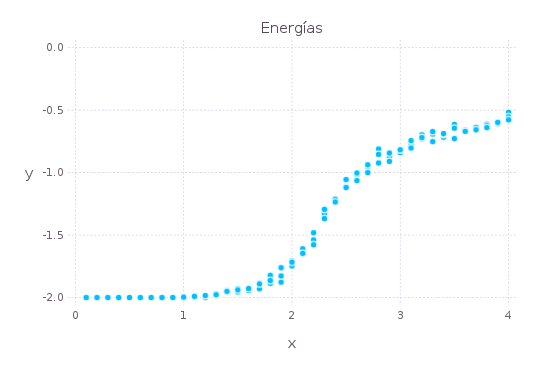

In [17]:
en_plot = plot(en_layers..., Guide.title("Energías"), Theme(background_color="white"))
#img = PNG(directory*"energias.png", 6inch, 4inch)
#draw(img, en_plot)

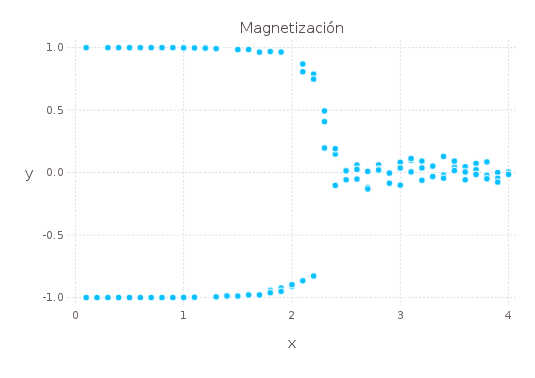

In [18]:
mag_plot = plot(mag_layers..., Guide.title("Magnetización"), Theme(background_color="white"))
#img = PNG(directory*"magnetizaciones.png", 6inch, 4inch)
#draw(img, mag_plot)